In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt
from subprocess import check_output
import numpy as np
import os
from scipy.ndimage import affine_transform
import SimpleITK as sitk
import cv2
from scipy.stats import skew
from abakit.lib.utilities_registration import register_simple
from PIL import Image

In [2]:
def parameters_to_rigid_transform(rotation, xshift, yshift, center):
    rotation, xshift, yshift = np.array([rotation, xshift, yshift]).astype(np.float16)
    center = np.array(center).astype(np.float16)
    R = np.array([[np.cos(rotation), -np.sin(rotation)],
                    [np.sin(rotation), np.cos(rotation)]])
    shift = center + (xshift, yshift) - np.dot(R, center)
    T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
    return T

def get_rotation_center(INPUT):
    files = sorted(os.listdir(INPUT))
    midpoint = len(files) // 2
    midfilepath = os.path.join(INPUT, files[midpoint])
    width,height = get_image_size(midfilepath)
    center = np.array([width, height]) / 2
    return center

def get_image_size(filepath):
    result_parts = str(check_output(["identify", filepath]))
    results = result_parts.split()
    width, height = results[2].split('x')
    return int(width), int(height)

def parameters_to_rigid_transform(rotation, xshift, yshift, center):
    rotation, xshift, yshift = np.array([rotation, xshift, yshift]).astype(np.float16)
    center = np.array(center).astype(np.float16)
    R = np.array([[np.cos(rotation), -np.sin(rotation)],
                    [np.sin(rotation), np.cos(rotation)]])
    shift = center + (xshift, yshift) - np.dot(R, center)
    T = np.vstack([np.column_stack([R, shift]), [0, 0, 1]])
    return T

def find_principle_vector(mask):
    moments = cv2.moments(mask)
    x = moments['m10']/moments['m00']
    y = moments['m01']/moments['m00']
    u20 = moments['m20']/moments['m00'] - x**2
    u11 = moments['m11']/moments['m00'] - x*y
    u02 = moments['m02']/moments['m00'] - y**2
    theta = 0.5*np.arctan(2*u11/(u20-u02)) + (u20<u02)*np.pi/2
    x = moments['m10']/moments['m00']
    y = moments['m01']/moments['m00']
    center = np.array([x,y]).astype(int)
    return theta,center

def find_skewness_along_X(image):
    inds = np.argwhere(image>np.mean(image))
    return skew(inds[:,1])

def rotate_and_align_image(moving,fixed):
    moving_mask = np.array((np.array(moving)>np.mean(moving))*255).astype('uint8')
    fixed_mask = np.array((np.array(fixed)>np.mean(fixed))*255).astype('uint8')
    theta_moving,center_moving = find_principle_vector(moving_mask)
    theta_fixed,center_fixed = find_principle_vector(fixed_mask)
    straight_moving = moving.rotate(((theta_moving+2*np.pi)%(2*np.pi))/np.pi*180,center =list(center_moving))
    straight_fixed = fixed.rotate(((theta_fixed+2*np.pi)%(2*np.pi))/np.pi*180,center =list(center_fixed))
    skewness_moving = find_skewness_along_X(straight_moving)
    skewness_fixed = find_skewness_along_X(straight_fixed)
    if np.sign(skewness_fixed) != np.sign(skewness_moving):
        theta_moving = (theta_moving+np.pi)%(2*np.pi)
    rotation_angle = theta_fixed-theta_moving
    offset = center_fixed - center_moving
    rotation_angle = (theta_fixed-theta_moving+np.pi)%(2*np.pi)
    return rotation_angle,offset,center_moving

def plot_mask_with_principle_vector(theta,center,mask):
    slope = np.tan(theta)
    x = np.linspace(center[0],center[0]+500*np.cos(theta),100)
    y = slope*x+center[1]-center[0]*slope
    plt.figure()
    plt.imshow(mask)
    plt.plot(x,y,color = 'r')
    plt.scatter(x[-1],y[-1],color = 'r')

def plot_mask_with_principle_vector_quiver(theta,center,mask):
    plt.figure()
    plt.imshow(mask)
    plt.quiver(center[0],center[1],np.cos(theta),np.sin(theta),units = 'width',color = 'r')

def test_image(image):
    mask = np.array((image>np.mean(image))*255).astype('uint8')
    theta,center = find_principle_vector(mask)
    plot_mask_with_principle_vector(theta,center,mask)
    return principle_vec

In [3]:
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK55/preps/CH1/thumbnail_cleaned/'
test_dir = '/home/zhw272/test/'
pixelType = sitk.sitkFloat32
fixed_file = os.path.join(INPUT, f'{195}.tif')
moving_file = os.path.join(INPUT, f'{196}.tif')

In [11]:
image = Image.open(moving_file)
imager = image.copy()
for i in range(12):
    imager = imager.rotate(60)
    imager.save(test_dir+f'{i+1:03}.tif')
image.save(test_dir+f'000.tif')

In [22]:
initial_transform = sitk.Euler2DTransform()
initial_transform.SetParameters([rotation_angle,*offset.astype(float)])
# initial_transform.SetParameters([1.5,2,3])
print(initial_transform)

itk::simple::Euler2DTransform
 Euler2DTransform (0x30be100)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1487
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.499951 -0.866054 
     0.866054 0.499951 
   Offset: [-9, -2]
   Center: [0, 0]
   Translation: [-9, -2]
   Inverse: 
     0.499951 0.866054 
     -0.866054 0.499951 
   Singular: 0
   Angle       = 1.04725



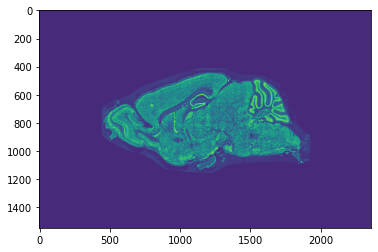

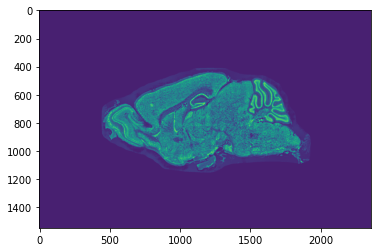

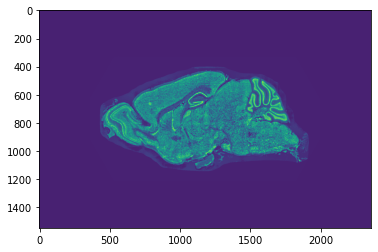

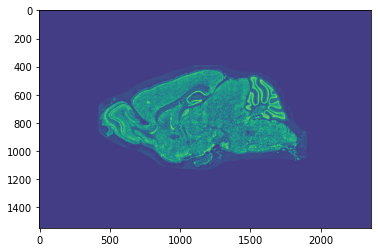

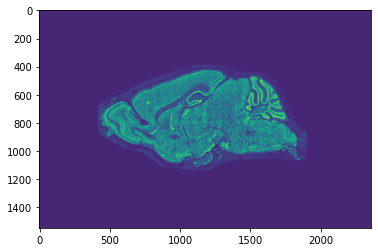

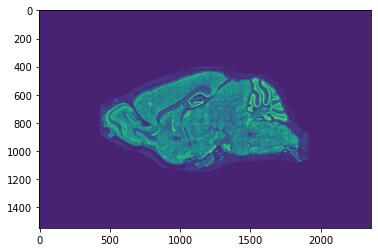

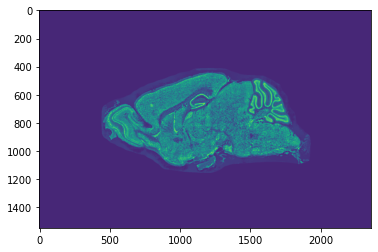

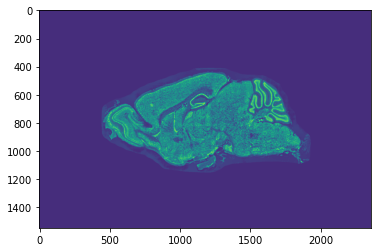

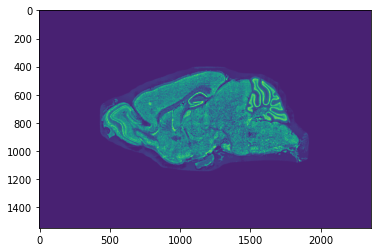

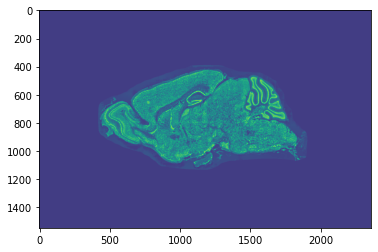

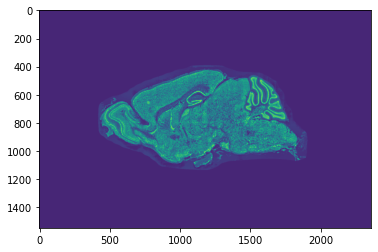

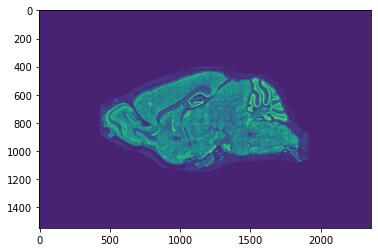

In [12]:
for i in range(12):
    a,b = register_simple(test_dir,'000',f'{i+1:03}',debug=False)
    pixelType = sitk.sitkFloat32
    moving = os.path.join(test_dir, f'{i+1:03}.tif')
    moving = sitk.ReadImage(moving, pixelType)
    moving = sitk.GetArrayFromImage(moving)
    T = parameters_to_rigid_transform(*b)
    fin = affine_transform(moving,T)
    plt.figure()
    plt.imshow(fin)